In [1]:
import sys
sys.path.append("./Tagging/lib/python3.6/site-packages")

import numpy as np
import pandas as pd

import re

import matplotlib.pyplot as plt

#Locate and list all xlms files so they can be opened all together

import os

xlms_files = []
for root, dirs, files in os.walk("."):  
    for filename in files:
        if filename[-4:]=='xlsm':  #Add to the list if the element's last four spaces form the word "xlsm"
            xlms_files += [filename]
        
xlms_files

['Rolls Royce Derby EOS Rotatives.xlsm',
 'Rolls Royce Jubilee House.xlsm',
 'Tag_50014000_Birmingham_Brindley_Place.xlsm',
 'Tag_50888200_Bristol_Canons_House.xlsm',
 'Tag_50111119_Gillingham_Operations_Centre.xlsm',
 'Tag_50964119_Chester_Tower_House.xlsm',
 'Tag_50963957_Edinburgh_Sighthill_North_IT_Centre.xlsm',
 'Tag_50450069_Andover_Keens_House.xlsm',
 'Tag_50963912_Cheadle_Heath_Heathside_Park.xlsm',
 'Vodafone Atlas Park.xlsm',
 'Tag_50575100_Bristol_Wine_Street_-_Bank_House.xlsm',
 'Rolls Royce Heathrow.xlsm',
 'Tag_50963969_Leeds_Wellington_Street.xlsm',
 'Rolls Royce Barnoldswick.xlsm',
 'Tag_50940656_Gloucester_Barnwood_1_Barnett_Way.xlsm',
 'Tag_50450189_Manchester_Brotherton_House.xlsm']

In [2]:
#concatenate all files into a huge dataset

inputs = []

for file in xlms_files:
    file = "Spreadsheets/" + file
    xl = pd.ExcelFile(file)
    if "Input" in xl.sheet_names:
        df = xl.parse('Output for SkySpark') #Go to "Tagging" tab
        inputs += [df] 

inputs = pd.concat(inputs) #Concatenate them one below the next one
inputs = inputs.dropna(subset=["service"]) #Drop row if service value is equals zero
inputs = inputs.reset_index() #Restart the index from zero to its length
inputs = inputs.drop(columns=["index"]) #Drop old index

inputs

pointId                        siteLabel      service  \
0            1  Rolls Royce Derby EOS Rotatives      Cooling   
1            2  Rolls Royce Derby EOS Rotatives      Cooling   
2            3  Rolls Royce Derby EOS Rotatives      Cooling   
3            4  Rolls Royce Derby EOS Rotatives      Cooling   
4            5  Rolls Royce Derby EOS Rotatives      Cooling   
5            6  Rolls Royce Derby EOS Rotatives      Cooling   
6            7  Rolls Royce Derby EOS Rotatives      Cooling   
7            8  Rolls Royce Derby EOS Rotatives      Cooling   
8            9  Rolls Royce Derby EOS Rotatives      Cooling   
9           10  Rolls Royce Derby EOS Rotatives      Cooling   
10          11  Rolls Royce Derby EOS Rotatives      Cooling   
11          12  Rolls Royce Derby EOS Rotatives      Cooling   
12          13  Rolls Royce Derby EOS Rotatives      Cooling   
13          14  Rolls Royce Derby EOS Rotatives      Cooling   
14          15  Rolls Royce Derby EOS Rotatives      Cooling   
15          16  Rolls Royce Derby EOS Rotatives      Cooling   
16          17  Rolls Royce Derby EOS Rotatives      Cooling   
17          18  Rolls Royce Derby EOS Rotatives      Cooling   
18          19  Rolls Royce Derby EOS Rotatives      Cooling   
19          20  Rolls Royce Derby EOS Rotatives      Cooling   
20          21  Rolls Royce Derby EOS Rotatives      Cooling   
21          22  Rolls Royce Derby EOS Rotatives      Cooling   
22          23  Rolls Royce Derby EOS Rotatives      Cooling   
23          24  Rolls Royce Derby EOS Rotatives      Cooling   
24          25  Rolls Royce Derby EOS Rotatives      Cooling   
25          26  Rolls Royce Derby EOS Rotatives      Cooling   
26          27  Rolls Royce Derby EOS Rotatives      Cooling   
27          28  Rolls Royce Derby EOS Rotatives      Cooling   
28          29  Rolls Royce Derby EOS Rotatives      Cooling   
29          30  Rolls Royce Derby EOS Rotatives      Cooling   
...        ...                              ...          ...   
15229      491        50450189 Brotherton House      Cooling   
15230      492        50450189 Brotherton House      Cooling   
15231      493        50450189 Brotherton House      Cooling   
15232      494        50450189 Brotherton House      Cooling   
15233      495        50450189 Brotherton House      Cooling   
15234      496        50450189 Brotherton House      Cooling   
15235      497        50450189 Brotherton House      Cooling   
15236      498        50450189 Brotherton House      Heating   
15237      499        50450189 Brotherton House      Heating   
15238      500        50450189 Brotherton House      Heating   
15239      501        50450189 Brotherton House      Heating   
15240      502        50450189 Brotherton House      Heating   
15241      503        50450189 Brotherton House      Heating   
15242      504        50450189 Brotherton House      Heating   
15243      505        50450189 Brotherton House      Heating   
15244      506        50450189 Brotherton House      Heating   
15245      507        50450189 Brotherton House      Heating   
15246      508        50450189 Brotherton House      Heating   
15247      509        50450189 Brotherton House      Heating   
15248      510        50450189 Brotherton House  Ventilation   
15249      511        50450189 Brotherton House  Ventilation   
15250      512        50450189 Brotherton House  Ventilation   
15251      513        50450189 Brotherton House  Ventilation   
15252      514        50450189 Brotherton House  Ventilation   
15253      515        50450189 Brotherton House  Ventilation   
15254      516        50450189 Brotherton House  Ventilation   
15255      517        50450189 Brotherton House  Ventilation   
15256      518        50450189 Brotherton House  Ventilation   
15257      519        50450189 Brotherton House  Ventilation   
15258      520        50450189 Brotherton House  Ventilation   

                 equipName      equipT

In [3]:
class SequenceIterator:
    def __init__(self, dataset, label_points, ref_points, outputs, dictionary):
        
        self.dataset = dataset
        self.label_points = label_points
        self.ref_points = ref_points
        self.outputs = outputs
        
        self.labels = dataset[label_points]
        self.refs = dataset[ref_points]
        self.y = dataset[outputs]
        
        self.dictionary = dictionary
              
    def __iter__(self):
        for label,ref,tags in zip(self.labels, self.refs, self.y):
            
            label = label + " " + ref[0]
            #Eliminate numbers?
            label = re.sub(r"[0-9]","",label)
            #Lower case characters
            label = label.lower().split()
            
            tags = re.sub(",","",tags)
            tags = tags.split()
            
            #Clean it from dictionary            
            for i in range(0,len(label)):
                if label[i] in dictionary:
                    label[i] = dictionary[label[i]][0]
                    
            words = [w for w in label]
            
            yield words, tags

In [4]:
dictionary = pd.read_csv("dict.csv",header=None).set_index(0).T.to_dict("list")

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  """Entry point for launching an IPython kernel.


In [5]:
sentences = SequenceIterator(inputs, "pointLabel", "pointRef", "pointTags", dictionary)

In [6]:
y = []
words = []

for label, tags in sentences:
    words += [label]
    y += [tags]

In [7]:
y

[['cmd'],
 ['sensor', 'pressure', 'air'],
 ['sensor', 'pressure', 'air'],
 ['sp', 'pressure', 'air', 'oneA'],
 ['sp', 'oneA'],
 ['sp', 'oneA'],
 ['sensor', 'temp', 'air'],
 ['sensor', 'alarm'],
 ['sensor', 'alarm'],
 ['sensor', 'alarm'],
 ['sensor', 'alarm'],
 ['sensor', 'alarm'],
 ['sensor', 'alarm'],
 ['sensor', 'alarm'],
 ['sensor', 'alarm'],
 ['sensor', 'alarm'],
 ['sensor'],
 ['sensor'],
 ['sensor'],
 ['sensor'],
 ['sensor'],
 ['sensor'],
 ['sensor'],
 ['sensor'],
 ['sensor'],
 ['sensor'],
 ['cmd'],
 ['cmd'],
 ['sp', 'oneA'],
 ['sensor', 'alarm'],
 ['sensor', 'alarm'],
 ['sensor', 'temp', 'water', 'chilled'],
 ['sensor', 'temp', 'water', 'chilled'],
 ['occupied', 'oneA'],
 ['cmd'],
 ['cmd'],
 ['sp', 'oneA'],
 ['sensor', 'alarm'],
 ['sensor', 'alarm'],
 ['sensor', 'temp', 'water', 'chilled'],
 ['sensor', 'temp', 'water', 'chilled'],
 ['occupied', 'oneA'],
 ['cmd'],
 ['sp', 'oneA'],
 ['sp', 'oneA'],
 ['sensor', 'temp', 'air'],
 ['sensor', 'alarm'],
 ['sensor', 'alarm'],
 ['sensor', 

## word2vec embedding

In [8]:
import gensim

w2v_model = gensim.models.Word2Vec(words, size=5, window=10, min_count=2, workers=10)
#w2v_model.train(sentences, total_examples=len(sentences), epochs=10)

In [9]:
w2v_weights = w2v_model.wv.vectors
vocab_size, embedding_size = w2v_weights.shape

In [10]:
def word2token(word):
    try:    
        return w2v_model.wv.vocab[word].index
    # If word is not in index return 0. I realize this means that this
    # is the same as the word of index 0 (i.e. most frequent word), but 0s
    # will be padded later anyway by the embedding layer (which also
    # seems dirty but I couldn't find a better solution right now)
    except:
        return 0

def token2word(token):
    return w2v_model.wv.index2word[token]

/usr/lib/python3/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


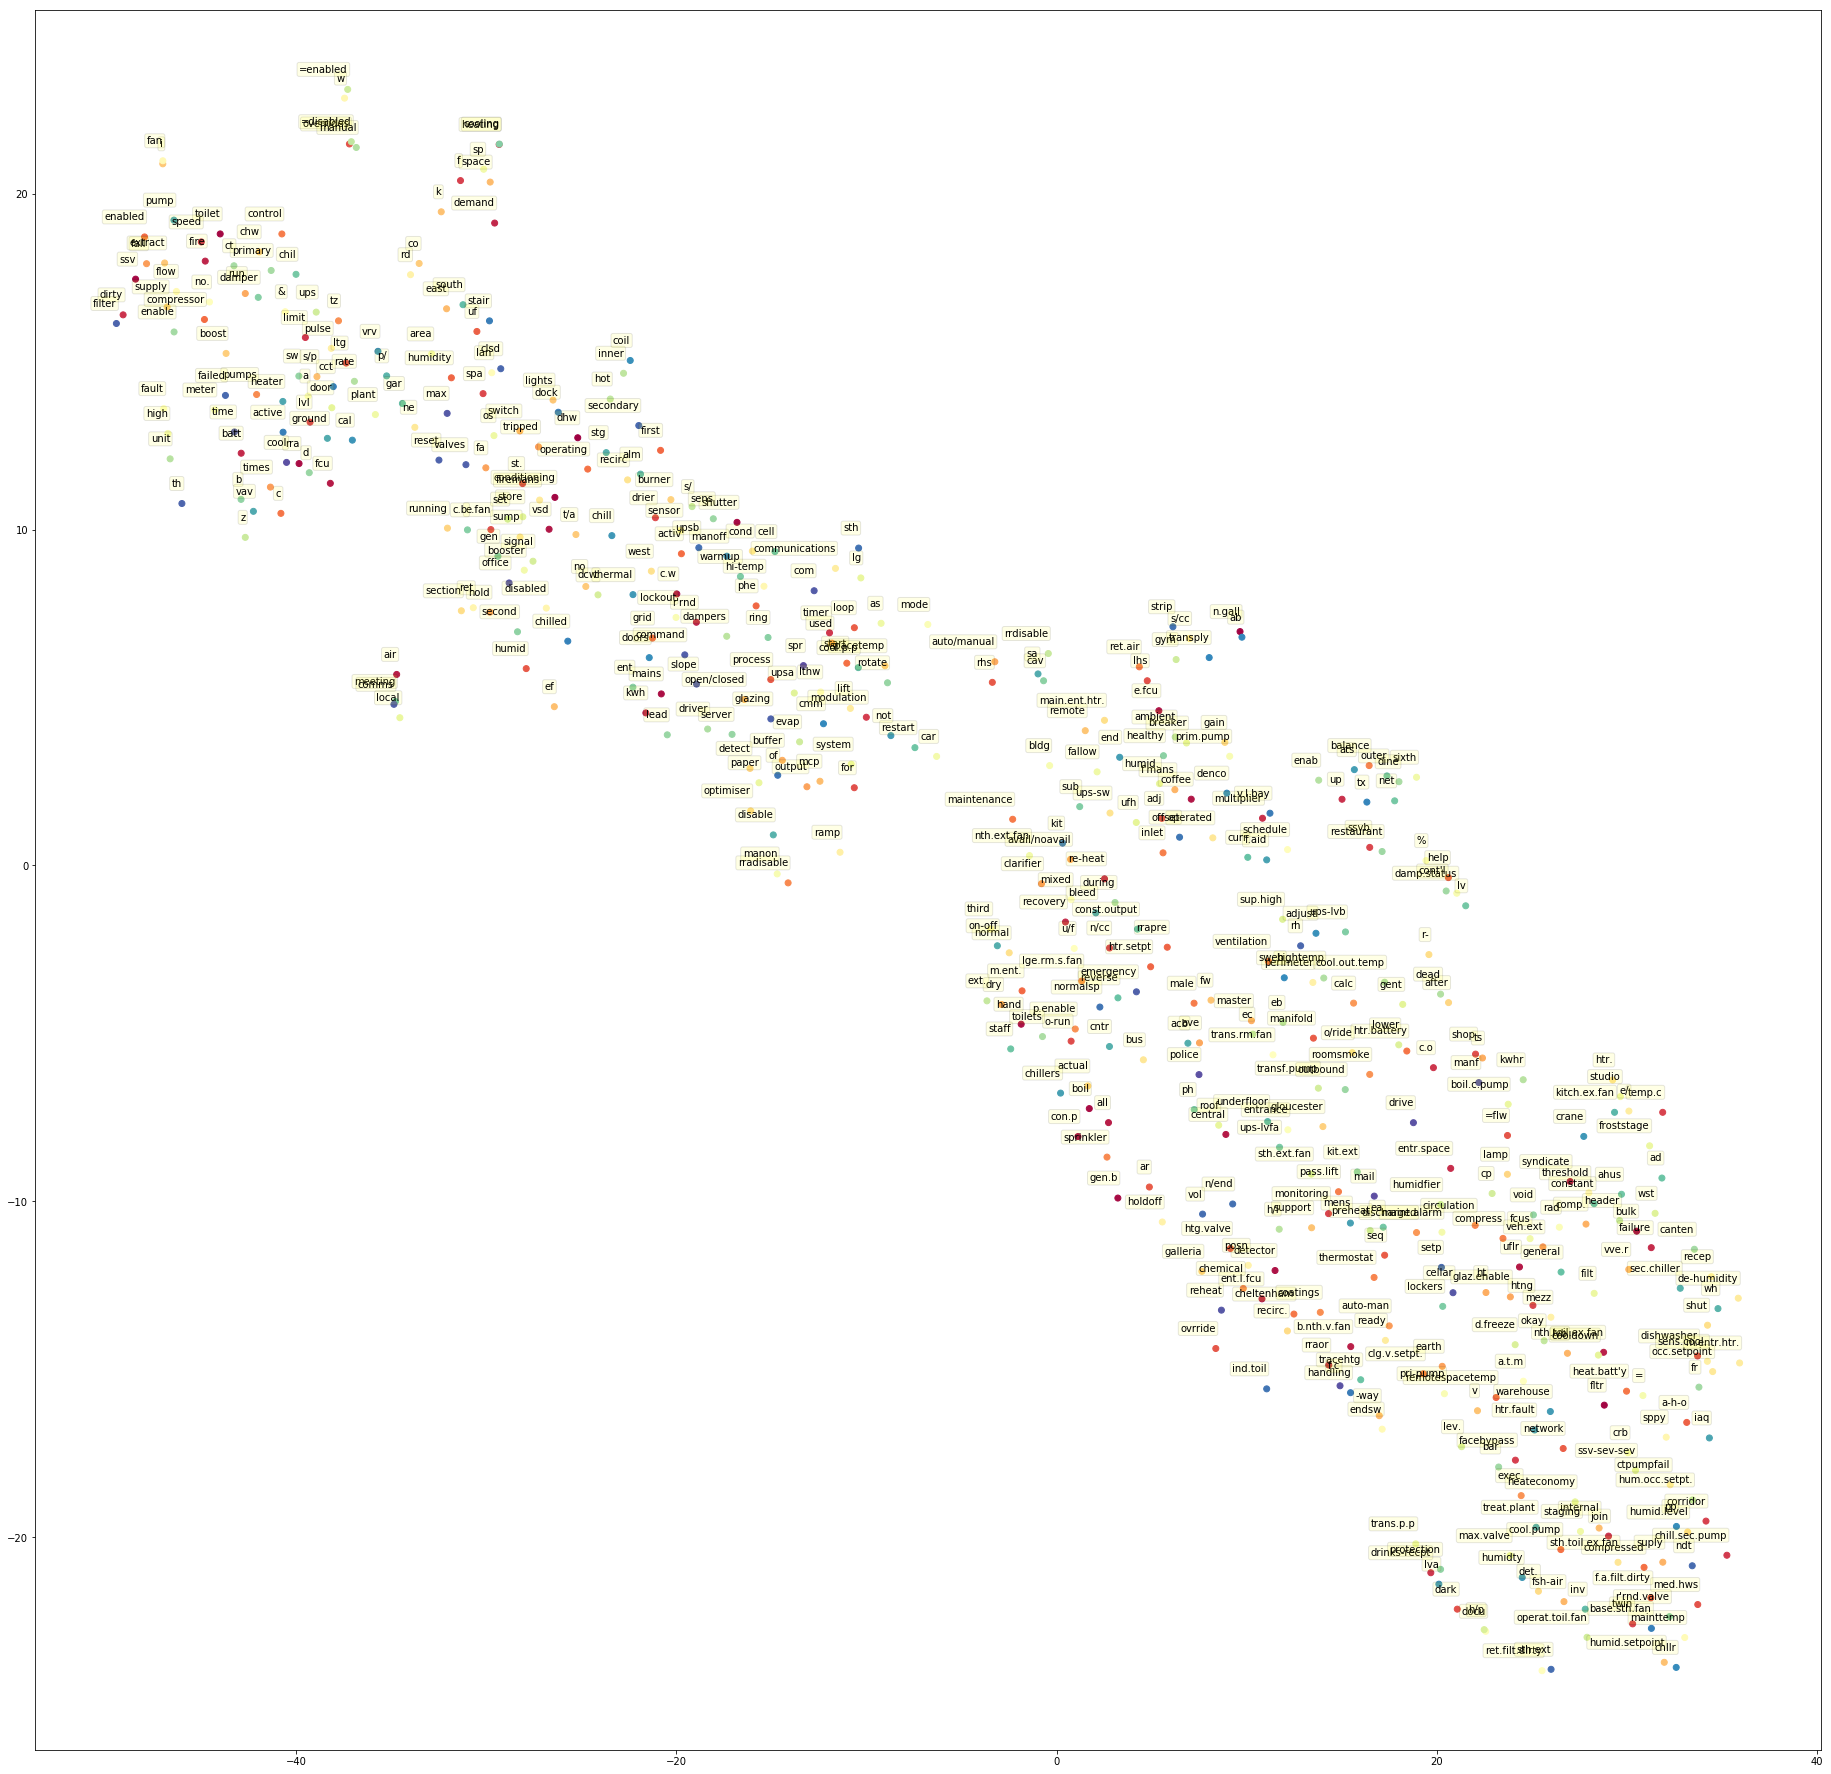

In [11]:
from sklearn.manifold import TSNE
import random

n_samples = 500
# Sample random words from model dictionary
random_i = random.sample(range(vocab_size), n_samples)
random_w = [token2word(i) for i in random_i]

# Generate Word2Vec embeddings of each word
word_vecs = np.array([w2v_model[w] for w in random_w])

# Apply t-SNE to Word2Vec embeddings, reducing to 2 dims
tsne = TSNE()
tsne_e = tsne.fit_transform(word_vecs)

# Plot t-SNE result
plt.figure(figsize=(32, 32))
plt.scatter(tsne_e[:, 0], tsne_e[:, 1], marker='o', c=range(len(random_w)), cmap=plt.get_cmap('Spectral'))

for label, x, y, in zip(random_w, tsne_e[:, 0], tsne_e[:, 1]):
    plt.annotate(label,
                 xy=(x, y), xytext=(0, 15),
                 textcoords='offset points', ha='right', va='bottom',
                 bbox=dict(boxstyle='round, pad=0.2', fc='yellow', alpha=0.1))

## One-hot encoder output y

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(y)
unique_tags_listed = multilabel_binarizer.classes_
y_onehot = multilabel_binarizer.fit_transform(y)

In [13]:
[(y[i],y_onehot[i]) for i in range(0,len(y))]

[(['cmd'],
  array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0])),
 (['sensor', 'pressure', 'air'],
  array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0])),
 (['sensor', 'pressure', 'air'],
  array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0])),
 (['sp', 'pressure', 'air', 'oneA'],
  array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0])),
 (['sp', 'oneA'],
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0])),
 (['sp', 'oneA'],
  array([0

## Inputs (label + ref) encoded with word2vec

In [14]:
class SequenceIterator2:
    def __init__(self, dataset, label_points, ref_points, dictionary):
        
        self.dataset = dataset
        self.label_points = label_points
        self.ref_points = ref_points
        
        self.labels = dataset[label_points]
        self.refs = dataset[ref_points]
        
        self.dictionary = dictionary
              
    def __iter__(self):
        for label,ref in zip(self.labels, self.refs):
            
            label = label + " " + ref[0]
            #Eliminate numbers?
            label = re.sub(r"[0-9]","",label)
            #Lower case characters
            label = label.lower().split()
            
            #Clean it from dictionary           
            for i in range(0,len(label)):
                if label[i] in dictionary:
                    label[i] = dictionary[label[i]][0]
                    
            words = np.array([word2token(w) for w in label])
            
            yield words

In [15]:
sequences = SequenceIterator2(inputs,"pointLabel","pointRef",dictionary)

set_x = []
for labels in sequences:
    set_x.append(labels)

In [16]:
MAX_SEQUENCE_LENGTH = 0
for label in set_x:
    if len(label) > MAX_SEQUENCE_LENGTH:
        MAX_SEQUENCE_LENGTH = len(label)
        
MAX_SEQUENCE_LENGTH

8

In [17]:
from keras.preprocessing.sequence import pad_sequences

#Padding sequences with 0
set_x = pad_sequences(set_x, maxlen=MAX_SEQUENCE_LENGTH, padding="pre", value=0)
set_y = y_onehot

Using TensorFlow backend.


In [18]:
set_y.shape, set_x.shape

((15259, 46), (15259, 8))

## Splitting dataset in training and validation

In [19]:
VALID_PER = 0.08 #Percentage of the whole set taken for validation

total_samples = set_x.shape[0]
n_val = int(VALID_PER * total_samples)
n_train = total_samples - n_val

In [20]:
import random

random_i = random.sample(range(total_samples), total_samples)
#random_i[:n_train] generates a random list of the length of the training set, so there may be 
#elements untaken in there, therefore it is shuffled so it is better for training?
train_x = set_x[random_i[:n_train]]
train_y = set_y[random_i[:n_train]]
val_x = set_x[random_i[n_train:n_train+n_val]]
val_y = set_y[random_i[n_train:n_train+n_val]]

#Only for validation
val_labels = inputs["pointLabel"].values[random_i[n_train:n_train+n_val]]

In [21]:
repetitions = 1

train_x = np.repeat(train_x, repetitions, axis=0)
train_y = np.repeat(train_y, repetitions, axis=0)

In [22]:
print("Train Shapes - X: {} - Y: {}".format(train_x.shape, train_y.shape))
print("Val Shapes - X: {} - Y: {}".format(val_x.shape, val_y.shape))

Train Shapes - X: (14039, 8) - Y: (14039, 46)
Val Shapes - X: (1220, 8) - Y: (1220, 46)


In [23]:
number_of_tags = len(unique_tags_listed)
number_of_tags

46

## Defining and training LSTM model

In [34]:
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import SGD

model = Sequential()

# Keras Embedding layer with Word2Vec weights initialization
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    weights=[w2v_weights],
                    input_length=MAX_SEQUENCE_LENGTH,
                    mask_zero=True,
                    trainable=False))

model.add(Bidirectional(LSTM(150)))
model.add(Dense(number_of_tags, activation='sigmoid'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)


#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['top_k_categorical_accuracy'])
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics="accuracy")

history = model.fit(train_x, train_y, epochs=100, batch_size=100,
                    validation_data=(val_x, val_y), verbose=1)

TypeError: Type of `metrics` argument not understood. Expected a list or dictionary, found: accuracy

In [37]:
model.predict_classes(val_x).shape

(1220,)

In [30]:
predicted_proba = model.predict_proba(val_x)

In [38]:
trues = []

for i in range(0,predicted_proba.shape[0]):  
    out = np.around(predicted_proba[i], decimals = 1)
    out[out >= 0.01] = 1
    out[out < 0.01] = 0
    out = out.astype(int)
    trues += [np.array_equal(out, val_y[i])]

In [39]:
(len(trues)-trues.count(False))/len(trues)*100

31.229508196721312

In [40]:
j=1

val_y[j]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [41]:
val_x[j]

array([ 0,  0,  0,  0,  0, 58, 37,  1], dtype=int32)

In [37]:
predicted_proba[j]

array([7.9451585e-03, 2.3958635e-01, 1.3137658e-03, 3.5367805e-01,
       2.5550628e-03, 3.1003025e-03, 1.5913775e-03, 2.3605488e-03,
       6.3639628e-03, 1.5647255e-03, 9.0469504e-03, 3.3481888e-04,
       8.8699401e-04, 2.0626113e-04, 2.1809279e-03, 8.0967066e-04,
       1.6414585e-02, 1.3993698e-03, 4.9624190e-04, 4.2562317e-03,
       2.1472026e-03, 2.3025543e-04, 2.3002310e-02, 1.4524342e-02,
       9.4470585e-04, 3.8909821e-03, 1.6174755e-04, 2.8654891e-03,
       4.5446523e-02, 4.6959940e-01, 2.0192175e-03, 2.2606125e-02,
       2.5575660e-04, 5.0194282e-04, 3.9507492e-04, 1.1261051e-03,
       8.1056254e-03, 2.6335395e-03, 1.8684185e-03, 2.4850599e-03,
       4.8183287e-03], dtype=float32)

In [42]:
model.evaluate(val_x,val_y)

RuntimeError: You must compile your model before using it.

In [45]:
np.around(model.predict(val_x)[3], decimals = 2)

array([0.47, 0.52, 0.48, 0.5 , 0.51, 0.49, 0.49, 0.5 , 0.45, 0.46, 0.5 ,
       0.5 , 0.49, 0.5 , 0.53, 0.5 , 0.5 , 0.51, 0.55, 0.48, 0.49, 0.47,
       0.5 , 0.47, 0.51, 0.47, 0.47, 0.49, 0.5 , 0.5 , 0.46, 0.5 , 0.48,
       0.5 , 0.51, 0.5 , 0.44, 0.5 , 0.54, 0.49, 0.53, 0.5 , 0.52, 0.55,
       0.51, 0.49], dtype=float32)

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])
for category in categories:
    print('**Processing {} comments...**'.format(category))
    
    # Training logistic regression model on train data
    LogReg_pipeline.fit(train_x, train_y)
    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(val_x)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print("\n")

NameError: name 'categories' is not defined